<a href="https://colab.research.google.com/github/fcastellanosp/MINE-4206_202410_AML/blob/main/Talleres/Taller%203/Taller%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

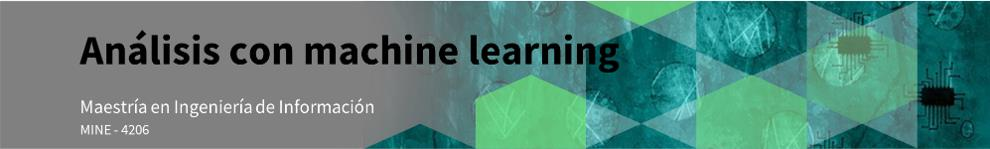

- **Integrante 1:** Lina María Gómez Mesa
- **Integrante 2:** María Catalina Ibáñez Piñeres

---
# Contexto y objetivos.

En la actualidad, la cantidad de artículos publicados en Internet está generando una gran ola de información accesible por cualquier usuario, dando a conocer diferentes puntos de vista, opiniones, información e investigaciones sobre diferentes temas de interés.

Esta gran cantidad de información no solo permite una búsqueda exhaustiva sobre un tema, también permite realizar un análisis sobre la tendencia de los diferentes temas que estén dando de qué hablar en una sociedad. Es por ello que un grupo de expertos se ha dado la tarea de analizar 10.000 artículos web y clasificarlos para poder establecer un análisis de los temas en la actualidad.

Para ello, como experto en análisis con machine learning, le han pedido que construya un modelo capaz de clasificar los nuevos artículos, realice un análisis de cuáles son los temas que dan de que hablar y automatice el proceso de selección y búsqueda de diferentes artículos.

**Objetivos de desarrollo**:

* Realizar el análisis y limpieza de textos.
* Explorar las diferentes técnicas de transformación de datos no estructurados.
* Establecer el mejor modelo basado en una red neuronal.

**Datos**: La fuente de los datos la puedes encontrar en [News Articles Classification Dataset for NLP & ML](https://www.kaggle.com/datasets/banuprakashv/news-articles-classification-dataset-for-nlp-and-ml).

# Entendimiento del negocio.

Para tener un mejor detalle sobre el comportamiento de las variables, solicitamos a la organización el diccionario de datos y nos suministró la siguiente información:

| ATRIBUTO | DEFINICIÓN |
| :- | :- |
| **headlines** | Titular del artículo.|
| **description** | Reseña del artículo.|
| **content** | Contenido del artículo.|
| **url** | Dirección web del artículo.|
| **category** | Representa la temática del artículo.|

# Actividades a realizar.

1. Realizar el análisis exploratorio de componentes principales en la información.

2. Identificar el número de componentes principales apropiado el procesamiento. Genera una tabla comparativa y los gráficos que apoyen este proceso. Recuerda que no deben truncarse los textos. Por último, la elección del número de componentes debe estar debidamente justificada.

3. Construir la red neuronal tomando como insumo los componentes principales procesados en el punto anterior.

4. Construir las gráficas de entrenamiento, validación. Debes interpretar los resultados obtenidos para este modelo base.

5. Realizar la identificación de hiperparámetros, justificando la elección de los valores correspondientes.

**NOTA**: La calificación será sobre notebook ejecutado y cargado en Bloque Neón junto con el archivo HTML.

# 0. Importar librerías

In [ ]:
!pip install pandas-profiling
!pip install contractions
!pip install polyglot
!pip install pyicu
!pip install pycld2
!pip install swifter

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [1]:
#Manejo de datos
import pandas as pd
import numpy as np

#Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Entrenamiento del modelo
import sklearn
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
#from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import classification_report, confusion_matrix, PrecisionRecallDisplay

#Textos

import contractions
import inflect
import nltk
import re, string, unicodedata
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from polyglot.detect import Detector
from wordcloud import WordCloud, STOPWORDS

#Tensorflow y keras
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

#Sistema operativo
import os
import os.path as osp

#Librerías extras
import itertools
from datetime import datetime

print(f"La versión de sklearn es: {sklearn.__version__}")
print(f'La versión de Tensor Flow es:', tf.__version__)

2024-04-14 10:31:46.293984: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 10:31:46.362628: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 10:31:46.364006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 10:31:47.399980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


La versión de sklearn es: 1.3.2
La versión de Tensor Flow es: 2.13.1


In [2]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/lgomez/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/lgomez/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/lgomez/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/lgomez/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/lgomez/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to
[nltk_data]    |

True

# 1. Introducción a los datos

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 14 10:32:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN X (Pascal)        On  | 00000000:02:00.0 Off |                  N/A |
| 49%   72C    P2              83W / 250W |   8232MiB / 12288MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1.1. Configuración del entorno de kaggle

Se hace la conexión con kaggle para poder descargar la base de datos.

In [ ]:
!ls -lha kaggle.json
!if [ ! -d ~/.kaggle ]; then mkdir ~/.kaggle; fi
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Se verifica la conectividad con el entorno de kaggle.

In [ ]:
!kaggle datasets list

Se descarga la base de datos.

In [ ]:
!kaggle datasets download banuprakashv/news-articles-classification-dataset-for-nlp-and-ml

In [4]:
ROOT_DIR = 'content'
DATASET_NAME = 'news-articles-classification-dataset-for-nlp-and-ml'

In [5]:
print(f"!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}")

!unzip news-articles-classification-dataset-for-nlp-and-ml.zip -d content/news-articles-classification-dataset-for-nlp-and-ml


Se descomprime el archivo en una carpeta previamente creada llamada content

In [ ]:
#%cd {ROOT_DIR}
!mkdir content
!mkdir content/{DATASET_NAME}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

Se genera la ruta del directorio para cargar la información.

In [6]:
DATA_DIR = f"{ROOT_DIR}/{DATASET_NAME}"
print(DATA_DIR)

content/news-articles-classification-dataset-for-nlp-and-ml


## 1.2. Separación de la información.

Se listan los archivos dentro de la carpeta

In [8]:
csv_files = os.listdir(DATA_DIR)

train_df = pd.DataFrame()
test_df = pd.DataFrame()

for csv_file in csv_files:
  new_df = pd.read_csv(osp.join(DATA_DIR, csv_file))
  train, test = train_test_split(new_df, test_size=0.2, random_state=19)
  train_df = pd.concat([train_df, train])
  test_df = pd.concat([test_df, test])

train_df.sample(5)

headlines  \
1832  HDFC Bank’s shares open at Rs 1,655 apiece on ...   
1410  Russia and Belarusian athletes at Asian Games:...   
626   Inside Alia Bhatt-Ranbir Kapoor’s ‘wholesome &...   
1943  Yes, airline flights are getting bumpier: here...   
1633  Schools of missing things: From toys, fans to ...   

                                            description  \
1832  The BSE Sensex touched a record high of 66,064...   
1410  Earlier this week, the Olympic Council of Asia...   
626   Shahid Kapoor and Mira Rajput rang in the new ...   
1943  The gross GST collection has crossed Rs 1.60 l...   
1633  Teachers blame broken boundary walls, lack of ...   

                                                content  \
1832  After hitting fresh all-time highs, supported ...   
1410  A ‘special quota system’ is currently being de...   
626   Celebrities rang in the New Year with their fa...   
1943  GST collections rose 12 per cent to over Rs 1....   
1633  As students of the Government Primary School i...   

                                                    url       category  
1832  https://indianexpress.com/article/business/mar...       business  
1410  https://indianexpress.com/article/sports/sport...         sports  
626   https://indianexpress.com/article/entertainmen...  entertainment  
1943  https://indianexpress.com/article/business/eco...       business  
1633  https://indianexpress.com/article/education/th...      education

Se mira el número de instancias para cada uno de los conjuntos de datos.

In [9]:
train_count = train_df.shape[0]
test_count = test_df.shape[0]

print("-------------------SEPARACIÓN DE LA INFORMACIÓN-------------------")
print(f"-> Train: {train_count:,}")
print(f"-> Test: {test_count:,}")

-------------------SEPARACIÓN DE LA INFORMACIÓN-------------------
-> Train: 8,000
-> Test: 2,000


Se verifican las categorías

In [10]:
train_df["category"].value_counts()

category
entertainment    1600
sports           1600
education        1600
technology       1600
business         1600
Name: count, dtype: int64

In [11]:
test_df["category"].value_counts()

category
entertainment    400
sports           400
education        400
technology       400
business         400
Name: count, dtype: int64

Se definen las variables X e Y para el modelo

In [12]:
target_feature = 'category'

In [13]:
x_feature = 'content'

Se genera una copia de la información para no modificar la original para el proceso exploratorio de transformación de los datos:

In [14]:
X_train_trans = train_df.copy()
X_train_trans

headlines  \
636   Rajinikanth fan mocks Vijay starrer The Greate...   
161   Agastya Nanda says he probably didn’t deserve ...   
855   Malaikottai Valiban new poster out: Mohanlal i...   
24    Hanu Man actor Teja Sajja on the responsibilit...   
252   Arun Matheswaran: ‘Captain Miller is my least ...   
...                                                 ...   
936   SEBI announces system to report demise of inve...   
1378  Air India launches 4-day sale on flights acros...   
757   4% inflation target top priority, show minutes...   
622   ‘EPFO in process of crediting 8.15% interest f...   
1629  Centre to consider PLI scheme for chemicals an...   

                                            description  \
636   A Rajinikanth fan shared a poster of Will Smit...   
161   Agastya Nanda also revealed why he did not fee...   
855   Lijo Jose Pellissery and Mohanlal have been ti...   
24    Teja Sajja and Prasanth Varma's Hanu Man has p...   
252   Arun Matheswaran calls Dhanush one of the shar...   
...                                                 ...   
936   After receiving intimation about the demise of...   
1378  Air India is offering fares starting from Rs 1...   
757   At this point of time, the guidance that the m...   
622   “...(Labour Minister) expressed satisfaction t...   
1629  On Thursday, the market regulator released gui...   

                                                content  \
636   Director Venkat Prabhu has never shied away fr...   
161   Actor Agastya Nanda, who was recently seen in ...   
855   If Kalki AD 2989 is the next big thing in the ...   
24    Actor Teja Sajja’s mythological film Hanu Man,...   
252   Speaking at the audio launch of Captain Miller...   
...                                                 ...   
936   The Securities and Exchange Board of India (SE...   
1378  Tata Group-owned Air India has launched a four...   
757   The Monetary Policy Committee (MPC) will remai...   
622   Union Labour and Employment Minister Bhupender...   
1629  The Union government has approved a scheme pro...   

                                                    url       category  
636   https://indianexpress.com/article/entertainmen...  entertainment  
161   https://indianexpress.com/article/entertainmen...  entertainment  
855   https://indianexpress.com/article/entertainmen...  entertainment  
24    https://indianexpress.com/article/entertainmen...  entertainment  
252   https://indianexpress.com/article/entertainmen...  entertainment  
...                                                 ...            ...  
936   https://indianexpress.com/article/business/seb...       business  
1378  https://indianexpress.com/article/business/avi...       business  
757   https://indianexpress.com/article/business/ban...       business  
622   https://indianexpress.com/article/business/epf...       business  
1629  https://indianexpress.com/article/business/eco...       business  

[8000 rows x 5 columns]

## 1.3. Exploración de los datos

Se va a generar un `WordCloud` para visualizar las palabras más frecuentes en las categorías.

Se inicia definiendo una función:

In [15]:
def show_wordcloud(palabras,stopwords=[]):
    comment_words = ''

    # iterate through the csv file
    for val in palabras:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

Se genera el llamada para cada una de las clases:

---------- Words for class: entertainment ----------


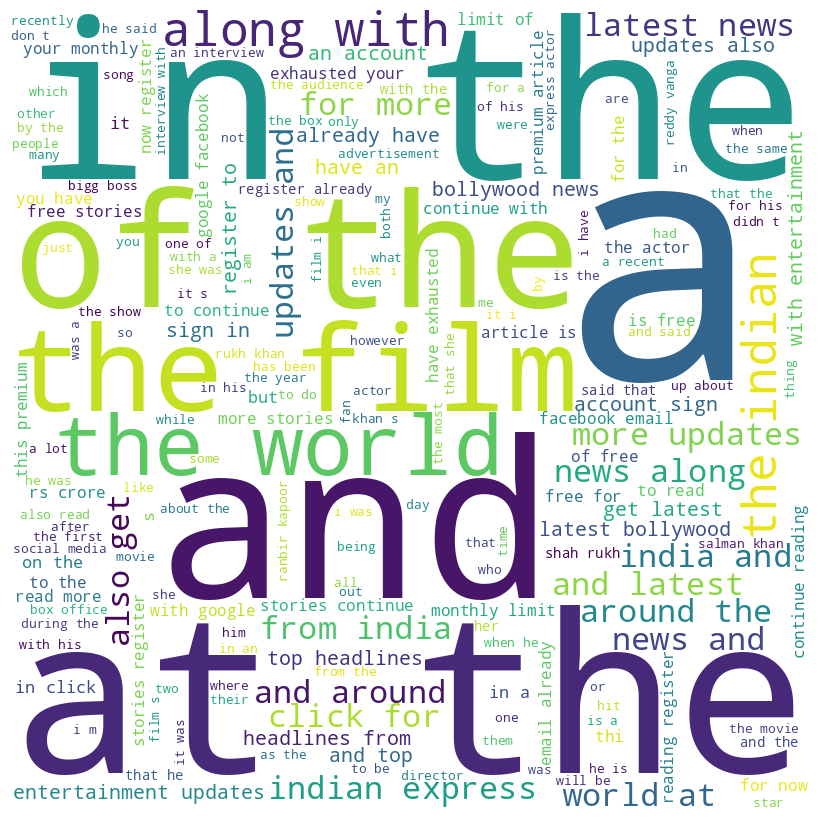

---------- Words for class: sports ----------


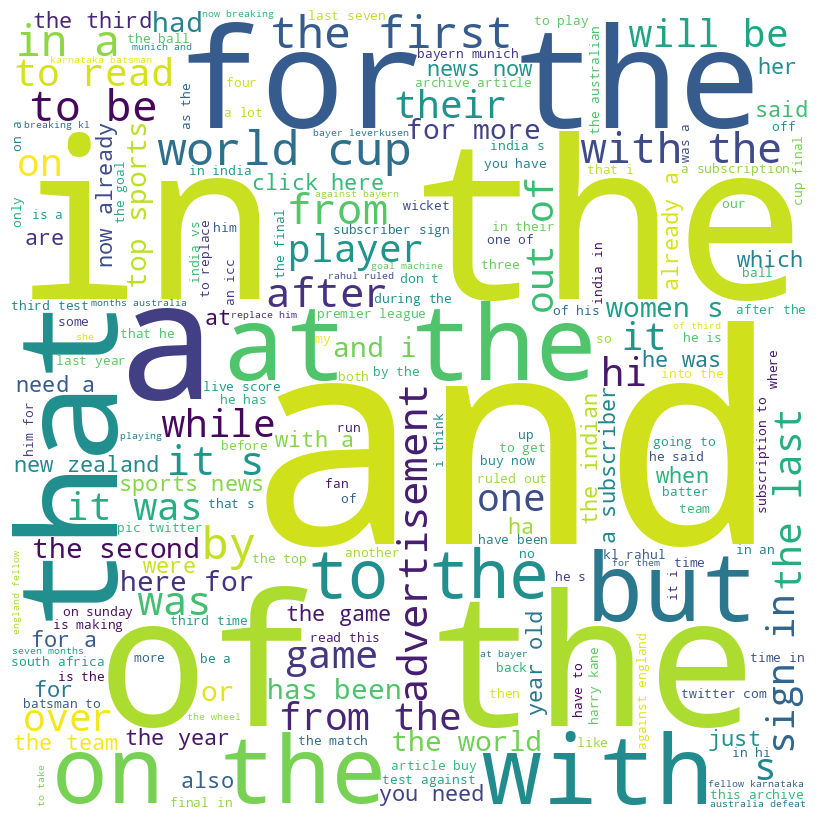

---------- Words for class: education ----------


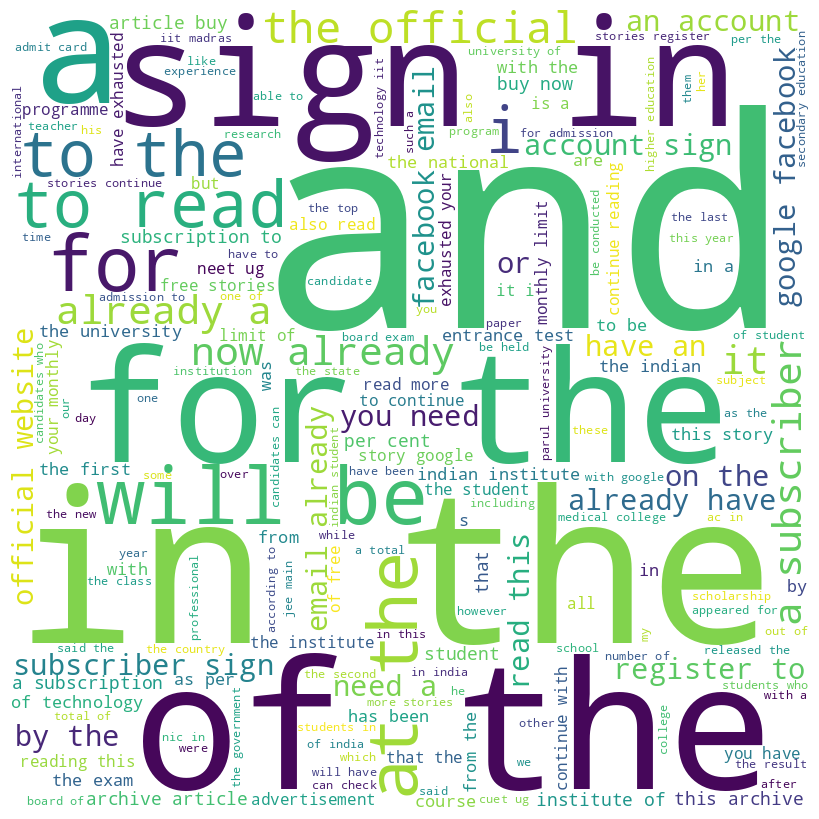

---------- Words for class: technology ----------


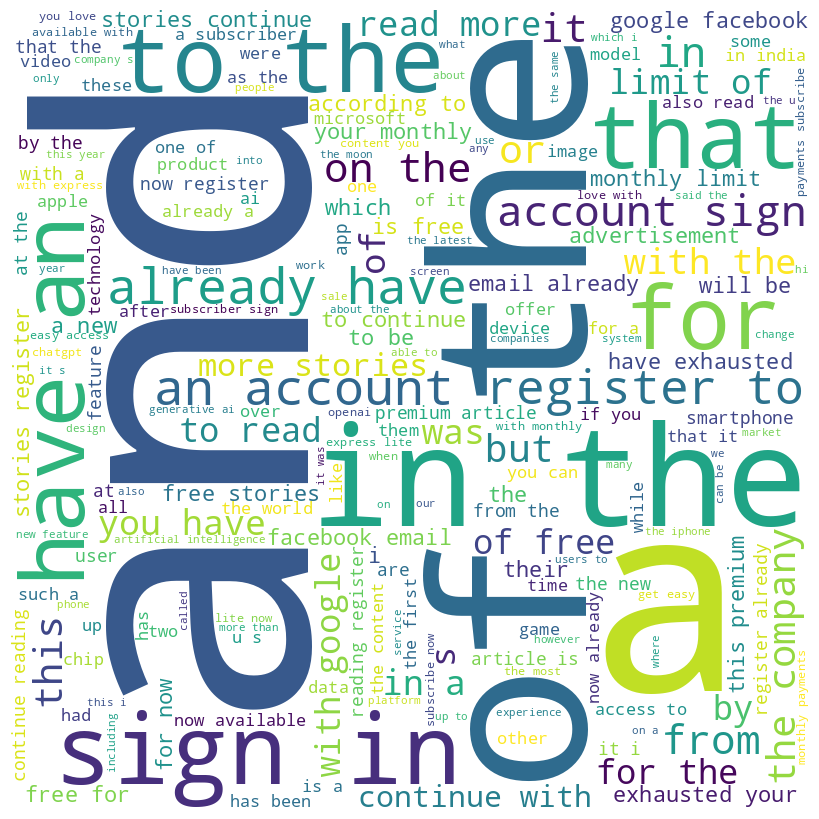

---------- Words for class: business ----------


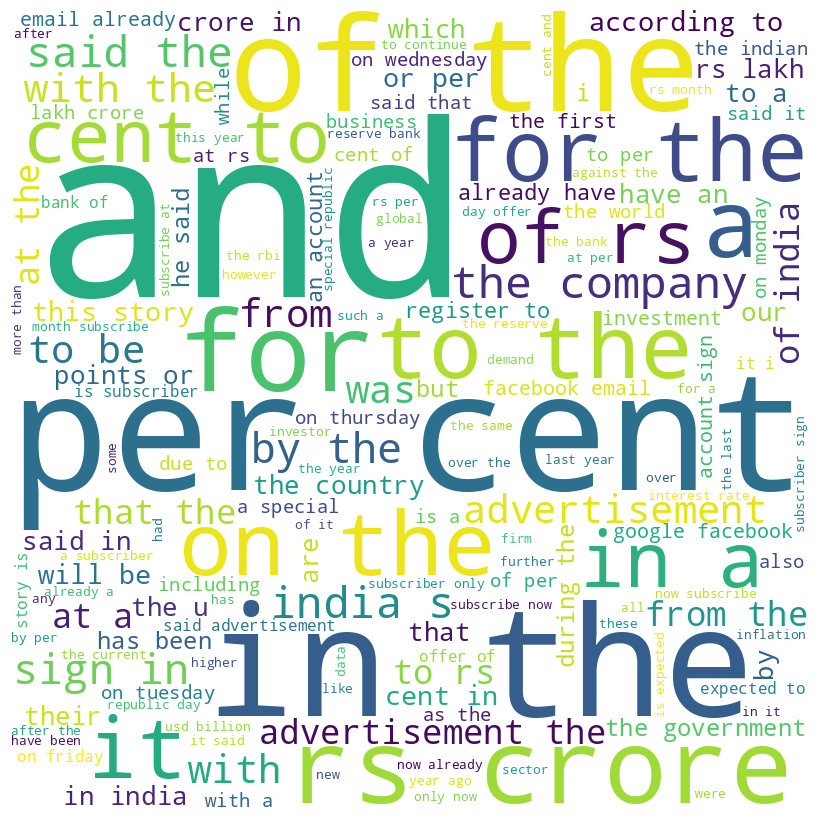

In [16]:
for i in train_df[target_feature].unique():
    print(f'---------- Words for class: {i} ----------')
    show_wordcloud(train_df.loc[train_df[target_feature]==i, x_feature])

Como se puede ver, hay varias palabras que se repiten en las diferentes categorías, lo que puede generar ruido en el modelo, ya que no aportan mucha información, esas palabras se conocen como `stopwords`. Se va a proceder a eliminarlas y a realizar un nuevo `WordCloud` para visualizar las palabras más frecuentes en las categorías.

In [17]:
stop_words = stopwords.words('english')

---------- Words for class: entertainment ----------


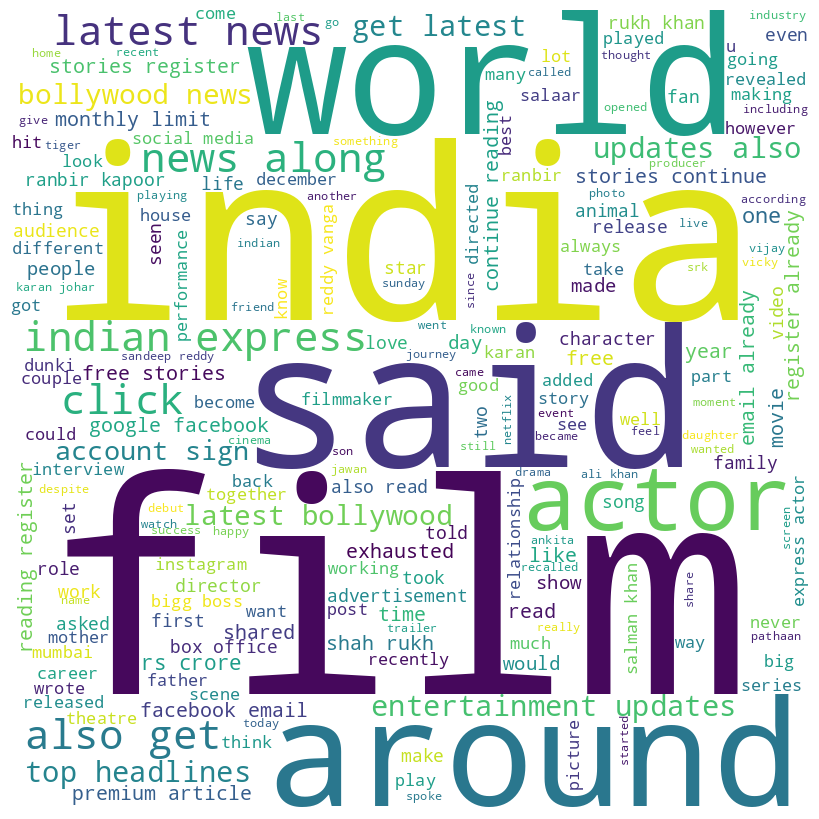

---------- Words for class: sports ----------


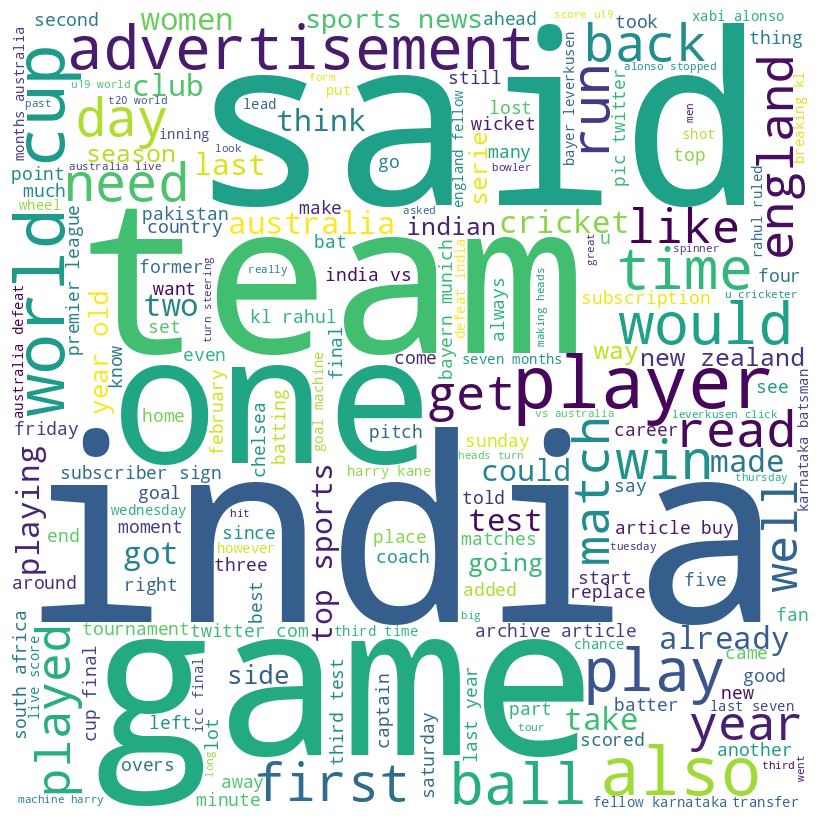

---------- Words for class: education ----------


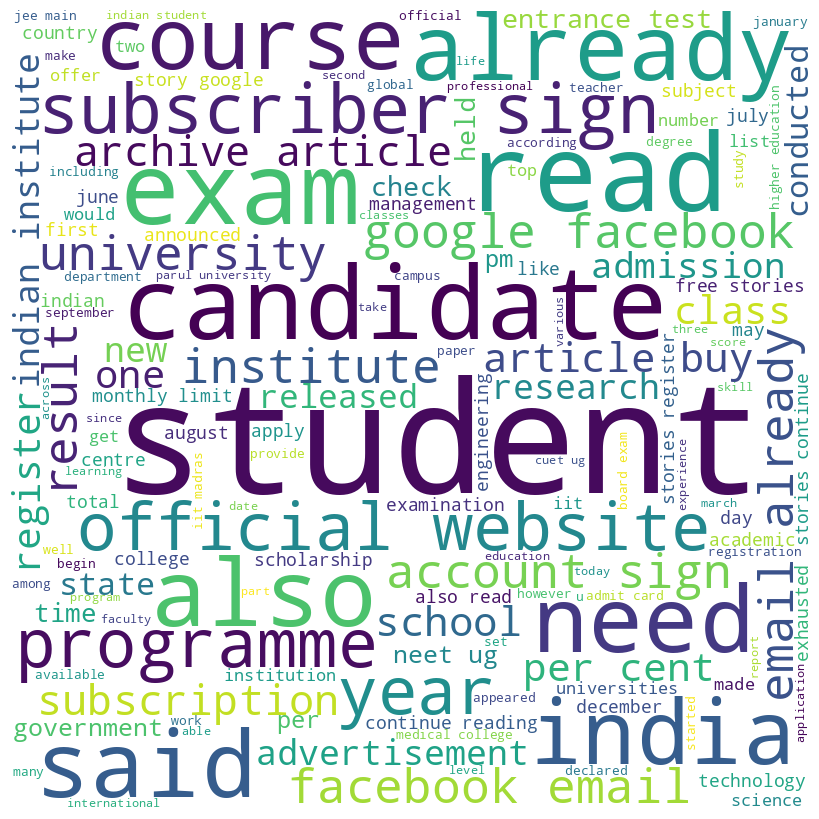

---------- Words for class: technology ----------


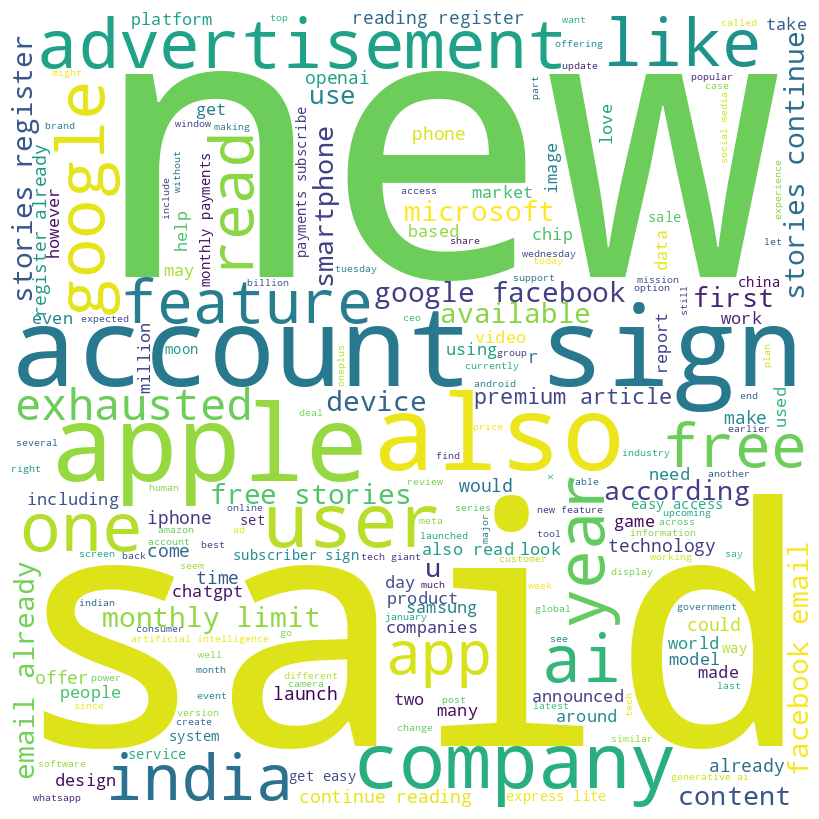

---------- Words for class: business ----------


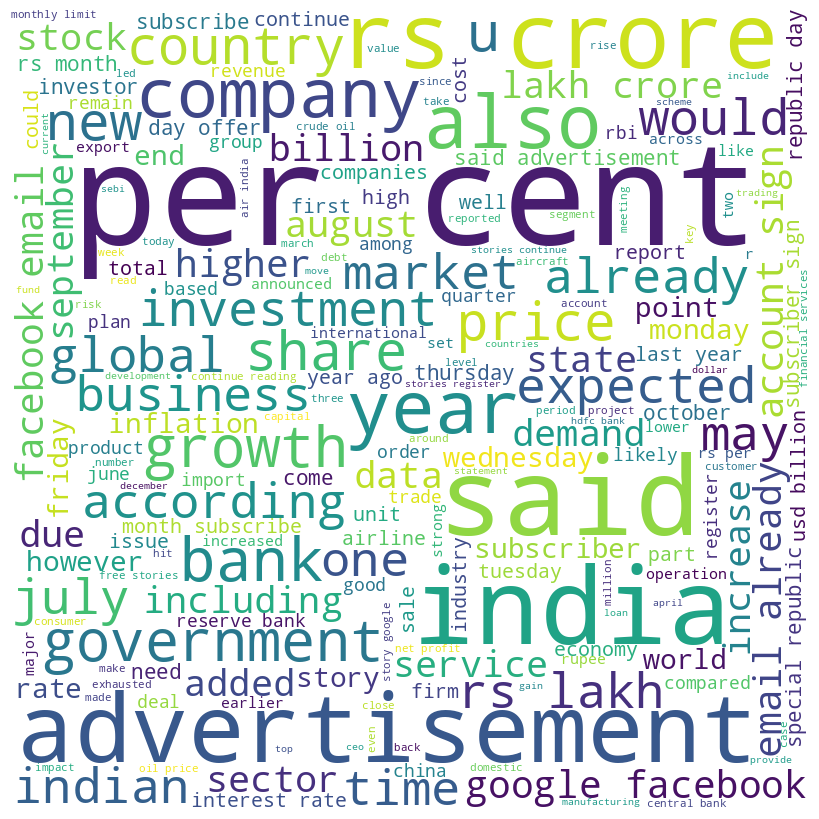

In [18]:
for i in train_df[target_feature].unique():
    print(f'---------- Words for class: {i} ----------')
    show_wordcloud(train_df.loc[train_df[target_feature]==i, x_feature], stop_words)

Asimismo, es importante revisar que todas las palabras se encuentren en el mismo idioma dado que este proceso es sensible al idioma. Para ello, se toma la función _set_language_ la cual utiliza la librería polyglot para reconocer en qué idioma se encuentra la mayoría de las filas. El resultado es que la mayoría se encuentra en: **inglés**.

In [19]:
def set_language(val):
  lang = Detector(str(val)).language.name.lower()
  return lang

train_df["language"] = train_df[x_feature].apply(set_language)
print(f"El lenguaje predominante es: {train_df['language'].unique()[0]}")

Detector is not able to detect the language reliably.


El lenguaje predominante es: english


**Nota**: Dado que el único que lenguaje que aparece es inglés no se eliminan registros.

## 1.4. Preparación de la información

Inicialmente, se separa tanto la variable objetivo como la variable independiente. Además, se convierte los valores targets en valores numéricos para que sean entendibles por el algoritmo.

In [20]:
label_encoder = LabelEncoder()
train_df[target_feature] = label_encoder.fit_transform(train_df[target_feature])
test_df[target_feature] = label_encoder.fit_transform(test_df[target_feature])

unique_labels = label_encoder.classes_
for num_value, original_label in enumerate(unique_labels):
    print(f'Valor numérico: {num_value}, Etiqueta original: {original_label}')

Valor numérico: 0, Etiqueta original: business
Valor numérico: 1, Etiqueta original: education
Valor numérico: 2, Etiqueta original: entertainment
Valor numérico: 3, Etiqueta original: sports
Valor numérico: 4, Etiqueta original: technology


Se realiza separación de _train_:

In [21]:
X_train, Y_train = train_df[x_feature], train_df[target_feature]
display(X_train)
Y_train

636     Director Venkat Prabhu has never shied away fr...
161     Actor Agastya Nanda, who was recently seen in ...
855     If Kalki AD 2989 is the next big thing in the ...
24      Actor Teja Sajja’s mythological film Hanu Man,...
252     Speaking at the audio launch of Captain Miller...
                              ...                        
936     The Securities and Exchange Board of India (SE...
1378    Tata Group-owned Air India has launched a four...
757     The Monetary Policy Committee (MPC) will remai...
622     Union Labour and Employment Minister Bhupender...
1629    The Union government has approved a scheme pro...
Name: content, Length: 8000, dtype: object

636     2
161     2
855     2
24      2
252     2
       ..
936     0
1378    0
757     0
622     0
1629    0
Name: category, Length: 8000, dtype: int64

Se realiza separación de _test_:

In [22]:
X_test, Y_test = test_df[x_feature], test_df[target_feature]
display(X_test)
Y_test

321     The Internet Movie Database (IMDb) has unveile...
1775    TV actors Divyanka Tripathi and Vivek Dahiya m...
953     Director Jude Anthany Joseph took to social me...
529     Deepika Padukone has always said that she and ...
1878    Actor Mansoor Ali Khan’s offensive and misogyn...
                              ...                        
1006    India will set carbon emission reduction targe...
1272    The average time taken for resolution or liqui...
1497    Indian wheat prices surged to a six-month high...
1756    Gautam Adani, Chairman of Adani Group on Tuesd...
921     In the run-up to Assembly polls in five states...
Name: content, Length: 2000, dtype: object

321     2
1775    2
953     2
529     2
1878    2
       ..
1006    0
1272    0
1497    0
1756    0
921     0
Name: category, Length: 2000, dtype: int64

Se propone:

- Eliminación del Ruido.
- Tokenización.
- Normalización.

In [23]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words, stopwords=stopwords.words('english')):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

#### 1.4.1 Tokenización

Ahora se aplica la función a la columna X_feature y se aplica el pre-procesamiento de los datos. Para ello se crea una función que realice las siguientes tareas:
* Pasar a minúsculas.
* Reemplazar los números por su correspondiente palabra.
* Eliminar los signos de puntuación.
* Eliminar caracteres especiales.
* Eliminar stopwords.

In [24]:
X_train_new = X_train.apply(word_tokenize)
X_train_new = X_train_new.apply(preprocessing) #Aplica la eliminación del ruido
X_train_new.head()

636    [director, venkat, prabhu, never, shied, away,...
161    [actor, agastya, nanda, recently, seen, zoya, ...
855    [kalki, ad, two thousand nine hundred and eigh...
24     [actor, teja, sajja, mythological, film, hanu,...
252    [speaking, audio, launch, captain, miller, dha...
Name: content, dtype: object

In [25]:
X_train_trans['trans'] = X_train_trans['content'].apply(nltk.word_tokenize,language="english").apply(preprocessing)
X_train_trans

headlines  \
636   Rajinikanth fan mocks Vijay starrer The Greate...   
161   Agastya Nanda says he probably didn’t deserve ...   
855   Malaikottai Valiban new poster out: Mohanlal i...   
24    Hanu Man actor Teja Sajja on the responsibilit...   
252   Arun Matheswaran: ‘Captain Miller is my least ...   
...                                                 ...   
936   SEBI announces system to report demise of inve...   
1378  Air India launches 4-day sale on flights acros...   
757   4% inflation target top priority, show minutes...   
622   ‘EPFO in process of crediting 8.15% interest f...   
1629  Centre to consider PLI scheme for chemicals an...   

                                            description  \
636   A Rajinikanth fan shared a poster of Will Smit...   
161   Agastya Nanda also revealed why he did not fee...   
855   Lijo Jose Pellissery and Mohanlal have been ti...   
24    Teja Sajja and Prasanth Varma's Hanu Man has p...   
252   Arun Matheswaran calls Dhanush one of the shar...   
...                                                 ...   
936   After receiving intimation about the demise of...   
1378  Air India is offering fares starting from Rs 1...   
757   At this point of time, the guidance that the m...   
622   “...(Labour Minister) expressed satisfaction t...   
1629  On Thursday, the market regulator released gui...   

                                                content  \
636   Director Venkat Prabhu has never shied away fr...   
161   Actor Agastya Nanda, who was recently seen in ...   
855   If Kalki AD 2989 is the next big thing in the ...   
24    Actor Teja Sajja’s mythological film Hanu Man,...   
252   Speaking at the audio launch of Captain Miller...   
...                                                 ...   
936   The Securities and Exchange Board of India (SE...   
1378  Tata Group-owned Air India has launched a four...   
757   The Monetary Policy Committee (MPC) will remai...   
622   Union Labour and Employment Minister Bhupender...   
1629  The Union government has approved a scheme pro...   

                                                    url       category  \
636   https://indianexpress.com/article/entertainmen...  entertainment   
161   https://indianexpress.com/article/entertainmen...  entertainment   
855   https://indianexpress.com/article/entertainmen...  entertainment   
24    https://indianexpress.com/article/entertainmen...  entertainment   
252   https://indianexpress.com/article/entertainmen...  entertainment   
...                                                 ...            ...   
936   https://indianexpress.com/article/business/seb...       business   
1378  https://indianexpress.com/article/business/avi...       business   
757   https://indianexpress.com/article/business/ban...       business   
622   https://indianexpress.com/article/business/epf...       business   
1629  https://indianexpress.com/article/business/eco...       business   

                                                  trans  
636   [director, venkat, prabhu, never, shied, away,...  
161   [actor, agastya, nanda, recently, seen, zoya, ...  
855   [kalki, ad, two thousand nine hundred and eigh...  
24    [actor, teja, sajja, mythological, film, hanu,...  
252   [speaking, audio, launch, captain, miller, dha...  
...                                                 ...  
936   [securities, exchange, board, india, sebi, tue...  
1378  [tata, groupowned, air, india, launched, fourd...  
757   [monetary, policy, committee, mpc, remain, foc...  
622   [union, labour, employment, minister, bhupende...  
1629  [union, government, approved, scheme, providin...  

[8000 rows x 6 columns]

#### 1.4.2 Normalización

Para la normalización de los datos se realiza una eliminación de prefijos y sufijos, además de realizar una lemmatización de los verbos.

In [26]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [27]:
X_train_new = X_train_new.apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
X_train_new.head()

636    [director, venkat, prabhu, never, shi, away, a...
161    [actor, agastya, nanda, recent, see, zoya, akh...
855    [kalki, ad, two thousand nine hundred and eigh...
24     [actor, teja, sajja, mytholog, film, hanu, man...
252    [speak, audio, launch, captain, miller, dhanus...
Name: content, dtype: object

In [28]:
X_train_trans['trans'] = X_train_trans['trans'].apply(stem_words)
X_train_trans

headlines  \
636   Rajinikanth fan mocks Vijay starrer The Greate...   
161   Agastya Nanda says he probably didn’t deserve ...   
855   Malaikottai Valiban new poster out: Mohanlal i...   
24    Hanu Man actor Teja Sajja on the responsibilit...   
252   Arun Matheswaran: ‘Captain Miller is my least ...   
...                                                 ...   
936   SEBI announces system to report demise of inve...   
1378  Air India launches 4-day sale on flights acros...   
757   4% inflation target top priority, show minutes...   
622   ‘EPFO in process of crediting 8.15% interest f...   
1629  Centre to consider PLI scheme for chemicals an...   

                                            description  \
636   A Rajinikanth fan shared a poster of Will Smit...   
161   Agastya Nanda also revealed why he did not fee...   
855   Lijo Jose Pellissery and Mohanlal have been ti...   
24    Teja Sajja and Prasanth Varma's Hanu Man has p...   
252   Arun Matheswaran calls Dhanush one of the shar...   
...                                                 ...   
936   After receiving intimation about the demise of...   
1378  Air India is offering fares starting from Rs 1...   
757   At this point of time, the guidance that the m...   
622   “...(Labour Minister) expressed satisfaction t...   
1629  On Thursday, the market regulator released gui...   

                                                content  \
636   Director Venkat Prabhu has never shied away fr...   
161   Actor Agastya Nanda, who was recently seen in ...   
855   If Kalki AD 2989 is the next big thing in the ...   
24    Actor Teja Sajja’s mythological film Hanu Man,...   
252   Speaking at the audio launch of Captain Miller...   
...                                                 ...   
936   The Securities and Exchange Board of India (SE...   
1378  Tata Group-owned Air India has launched a four...   
757   The Monetary Policy Committee (MPC) will remai...   
622   Union Labour and Employment Minister Bhupender...   
1629  The Union government has approved a scheme pro...   

                                                    url       category  \
636   https://indianexpress.com/article/entertainmen...  entertainment   
161   https://indianexpress.com/article/entertainmen...  entertainment   
855   https://indianexpress.com/article/entertainmen...  entertainment   
24    https://indianexpress.com/article/entertainmen...  entertainment   
252   https://indianexpress.com/article/entertainmen...  entertainment   
...                                                 ...            ...   
936   https://indianexpress.com/article/business/seb...       business   
1378  https://indianexpress.com/article/business/avi...       business   
757   https://indianexpress.com/article/business/ban...       business   
622   https://indianexpress.com/article/business/epf...       business   
1629  https://indianexpress.com/article/business/eco...       business   

                                                  trans  
636   [director, venkat, prabhu, never, shi, away, a...  
161   [actor, agastya, nanda, recent, seen, zoya, ak...  
855   [kalki, ad, two thousand nine hundred and eigh...  
24    [actor, teja, sajja, mytholog, film, hanu, man...  
252   [speak, audio, launch, captain, miller, dhanus...  
...                                                 ...  
936   [secur, exchang, board, india, sebi, tuesday, ...  
1378  [tata, groupown, air, india, launch, fourday, ...  
757   [monetari, polici, committe, mpc, remain, focu...  
622   [union, labour, employ, minist, bhupend, yadav...  
1629  [union, govern, approv, scheme, provid, comple...  

[8000 rows x 6 columns]

A continuación, se calculan algunas métricas:

In [29]:
X_train_trans['trans_count'] = X_train_trans['trans'].apply(lambda x: len(x))
X_train_trans

headlines  \
636   Rajinikanth fan mocks Vijay starrer The Greate...   
161   Agastya Nanda says he probably didn’t deserve ...   
855   Malaikottai Valiban new poster out: Mohanlal i...   
24    Hanu Man actor Teja Sajja on the responsibilit...   
252   Arun Matheswaran: ‘Captain Miller is my least ...   
...                                                 ...   
936   SEBI announces system to report demise of inve...   
1378  Air India launches 4-day sale on flights acros...   
757   4% inflation target top priority, show minutes...   
622   ‘EPFO in process of crediting 8.15% interest f...   
1629  Centre to consider PLI scheme for chemicals an...   

                                            description  \
636   A Rajinikanth fan shared a poster of Will Smit...   
161   Agastya Nanda also revealed why he did not fee...   
855   Lijo Jose Pellissery and Mohanlal have been ti...   
24    Teja Sajja and Prasanth Varma's Hanu Man has p...   
252   Arun Matheswaran calls Dhanush one of the shar...   
...                                                 ...   
936   After receiving intimation about the demise of...   
1378  Air India is offering fares starting from Rs 1...   
757   At this point of time, the guidance that the m...   
622   “...(Labour Minister) expressed satisfaction t...   
1629  On Thursday, the market regulator released gui...   

                                                content  \
636   Director Venkat Prabhu has never shied away fr...   
161   Actor Agastya Nanda, who was recently seen in ...   
855   If Kalki AD 2989 is the next big thing in the ...   
24    Actor Teja Sajja’s mythological film Hanu Man,...   
252   Speaking at the audio launch of Captain Miller...   
...                                                 ...   
936   The Securities and Exchange Board of India (SE...   
1378  Tata Group-owned Air India has launched a four...   
757   The Monetary Policy Committee (MPC) will remai...   
622   Union Labour and Employment Minister Bhupender...   
1629  The Union government has approved a scheme pro...   

                                                    url       category  \
636   https://indianexpress.com/article/entertainmen...  entertainment   
161   https://indianexpress.com/article/entertainmen...  entertainment   
855   https://indianexpress.com/article/entertainmen...  entertainment   
24    https://indianexpress.com/article/entertainmen...  entertainment   
252   https://indianexpress.com/article/entertainmen...  entertainment   
...                                                 ...            ...   
936   https://indianexpress.com/article/business/seb...       business   
1378  https://indianexpress.com/article/business/avi...       business   
757   https://indianexpress.com/article/business/ban...       business   
622   https://indianexpress.com/article/business/epf...       business   
1629  https://indianexpress.com/article/business/eco...       business   

                                                  trans  trans_count  
636   [director, venkat, prabhu, never, shi, away, a...           65  
161   [actor, agastya, nanda, recent, seen, zoya, ak...           92  
855   [kalki, ad, two thousand nine hundred and eigh...          109  
24    [actor, teja, sajja, mytholog, film, hanu, man...           79  
252   [speak, audio, launch, captain, miller, dhanus...           63  
...                                                 ...          ...  
936   [secur, exchang, board, india, sebi, tuesday, ...           54  
1378  [tata, groupown, air, india, launch, fourday, ...          193  
757   [monetari, polici, committe, mpc, remain, focu...           51  
622   [union, labour, employ, minist, bhupend, yadav...           58  
1629  [union, govern, approv, scheme, provid, comple...          357  

[8000 rows x 7 columns]

In [30]:
print(f"El número promedio de tokens es: {X_train_trans['trans_count'].mean()}")

El número promedio de tokens es: 134.212625


Finalmente, se une para que en vez de ser una lista sea un string únicamente:

In [31]:
train_df['trans'] = X_train_new.apply(lambda x: ' '.join(map(str, x)))
train_df

headlines  \
636   Rajinikanth fan mocks Vijay starrer The Greate...   
161   Agastya Nanda says he probably didn’t deserve ...   
855   Malaikottai Valiban new poster out: Mohanlal i...   
24    Hanu Man actor Teja Sajja on the responsibilit...   
252   Arun Matheswaran: ‘Captain Miller is my least ...   
...                                                 ...   
936   SEBI announces system to report demise of inve...   
1378  Air India launches 4-day sale on flights acros...   
757   4% inflation target top priority, show minutes...   
622   ‘EPFO in process of crediting 8.15% interest f...   
1629  Centre to consider PLI scheme for chemicals an...   

                                            description  \
636   A Rajinikanth fan shared a poster of Will Smit...   
161   Agastya Nanda also revealed why he did not fee...   
855   Lijo Jose Pellissery and Mohanlal have been ti...   
24    Teja Sajja and Prasanth Varma's Hanu Man has p...   
252   Arun Matheswaran calls Dhanush one of the shar...   
...                                                 ...   
936   After receiving intimation about the demise of...   
1378  Air India is offering fares starting from Rs 1...   
757   At this point of time, the guidance that the m...   
622   “...(Labour Minister) expressed satisfaction t...   
1629  On Thursday, the market regulator released gui...   

                                                content  \
636   Director Venkat Prabhu has never shied away fr...   
161   Actor Agastya Nanda, who was recently seen in ...   
855   If Kalki AD 2989 is the next big thing in the ...   
24    Actor Teja Sajja’s mythological film Hanu Man,...   
252   Speaking at the audio launch of Captain Miller...   
...                                                 ...   
936   The Securities and Exchange Board of India (SE...   
1378  Tata Group-owned Air India has launched a four...   
757   The Monetary Policy Committee (MPC) will remai...   
622   Union Labour and Employment Minister Bhupender...   
1629  The Union government has approved a scheme pro...   

                                                    url  category language  \
636   https://indianexpress.com/article/entertainmen...         2  english   
161   https://indianexpress.com/article/entertainmen...         2  english   
855   https://indianexpress.com/article/entertainmen...         2  english   
24    https://indianexpress.com/article/entertainmen...         2  english   
252   https://indianexpress.com/article/entertainmen...         2  english   
...                                                 ...       ...      ...   
936   https://indianexpress.com/article/business/seb...         0  english   
1378  https://indianexpress.com/article/business/avi...         0  english   
757   https://indianexpress.com/article/business/ban...         0  english   
622   https://indianexpress.com/article/business/epf...         0  english   
1629  https://indianexpress.com/article/business/eco...         0  english   

                                                  trans  
636   director venkat prabhu never shi away accept f...  
161   actor agastya nanda recent see zoya akhtar arc...  
855   kalki ad two thousand nine hundred and eightyn...  
24    actor teja sajja mytholog film hanu man garner...  
252   speak audio launch captain miller dhanush say ...  
...                                                 ...  
936   secur exchang board india sebi tuesday announc...  
1378  tata groupown air india launch fourday sale th...  
757   monetari polici committe mpc remain focus alig...  
622   union labour employ minist bhupend yadav wedne...  
1629  union govern approv scheme provid complet guar...  

[8000 rows x 7 columns]

### 1.5 Aplicación del Mismo Procesamiento a los Datos de Test

In [32]:
X_test_trans = test_df.copy()
X_test_trans

headlines  \
321   IMDb unveils list of most anticipated Indian m...   
1775  Vivek Dahiya was apprehensive about marrying D...   
953   2018 director Jude Anthany Joseph apologises a...   
529   Deepika Padukone says she’s looking forward to...   
1878  Mansoor Ali Khan’s remarks about Trisha are pa...   
...                                                 ...   
1006  India to set emission reduction mandates for 4...   
1272  Average time taken for IBC resolution at three...   
1497  India wheat prices jump to 6-month high on dem...   
1756  ADB retains India’s growth forecast at 6.4% fo...   
921   Govt hikes LPG subsidy for Ujjwala beneficiari...   

                                            description  \
321   According to the website, the list was compile...   
1775  When Vivek Dahiya was suggested the idea of ma...   
953   2018 director Jude Anthany Joseph has reacted ...   
529   In a new interview, Deepika Padukone shared th...   
1878  From Kamal Haasan kissing minor Rekha on-scree...   
...                                                 ...   
1006  India will set carbon emission reduction targe...   
1272  The timelines for the resolution of cases unde...   
1497  The increasing prices may prompt New Delhi to ...   
1756  The Adani Group saw a massive fall in market c...   
921   With Wednesday’s decision, a 14.2-kg domestic ...   

                                                content  \
321   The Internet Movie Database (IMDb) has unveile...   
1775  TV actors Divyanka Tripathi and Vivek Dahiya m...   
953   Director Jude Anthany Joseph took to social me...   
529   Deepika Padukone has always said that she and ...   
1878  Actor Mansoor Ali Khan’s offensive and misogyn...   
...                                                 ...   
1006  India will set carbon emission reduction targe...   
1272  The average time taken for resolution or liqui...   
1497  Indian wheat prices surged to a six-month high...   
1756  Gautam Adani, Chairman of Adani Group on Tuesd...   
921   In the run-up to Assembly polls in five states...   

                                                    url  category  
321   https://indianexpress.com/article/entertainmen...         2  
1775  https://indianexpress.com/article/entertainmen...         2  
953   https://indianexpress.com/article/entertainmen...         2  
529   https://indianexpress.com/article/entertainmen...         2  
1878  https://indianexpress.com/article/entertainmen...         2  
...                                                 ...       ...  
1006  https://indianexpress.com/article/business/eco...         0  
1272  https://indianexpress.com/article/business/ban...         0  
1497  https://indianexpress.com/article/business/ind...         0  
1756  https://indianexpress.com/article/business/mar...         0  
921   https://indianexpress.com/article/business/gov...         0  

[2000 rows x 5 columns]

In [33]:
X_test_new = X_train.apply(word_tokenize)
X_test_new = X_train_new.apply(preprocessing) #Aplica la eliminación del ruido
X_test_new.head()

636    [director, venkat, prabhu, never, shi, away, a...
161    [actor, agastya, nanda, recent, see, zoya, akh...
855    [kalki, ad, two thousand nine hundred and eigh...
24     [actor, teja, sajja, mytholog, film, hanu, man...
252    [speak, audio, launch, captain, miller, dhanus...
Name: content, dtype: object

In [34]:
X_test_trans['trans'] = X_test_trans['content'].apply(nltk.word_tokenize,language="english").apply(preprocessing)
X_test_trans

headlines  \
321   IMDb unveils list of most anticipated Indian m...   
1775  Vivek Dahiya was apprehensive about marrying D...   
953   2018 director Jude Anthany Joseph apologises a...   
529   Deepika Padukone says she’s looking forward to...   
1878  Mansoor Ali Khan’s remarks about Trisha are pa...   
...                                                 ...   
1006  India to set emission reduction mandates for 4...   
1272  Average time taken for IBC resolution at three...   
1497  India wheat prices jump to 6-month high on dem...   
1756  ADB retains India’s growth forecast at 6.4% fo...   
921   Govt hikes LPG subsidy for Ujjwala beneficiari...   

                                            description  \
321   According to the website, the list was compile...   
1775  When Vivek Dahiya was suggested the idea of ma...   
953   2018 director Jude Anthany Joseph has reacted ...   
529   In a new interview, Deepika Padukone shared th...   
1878  From Kamal Haasan kissing minor Rekha on-scree...   
...                                                 ...   
1006  India will set carbon emission reduction targe...   
1272  The timelines for the resolution of cases unde...   
1497  The increasing prices may prompt New Delhi to ...   
1756  The Adani Group saw a massive fall in market c...   
921   With Wednesday’s decision, a 14.2-kg domestic ...   

                                                content  \
321   The Internet Movie Database (IMDb) has unveile...   
1775  TV actors Divyanka Tripathi and Vivek Dahiya m...   
953   Director Jude Anthany Joseph took to social me...   
529   Deepika Padukone has always said that she and ...   
1878  Actor Mansoor Ali Khan’s offensive and misogyn...   
...                                                 ...   
1006  India will set carbon emission reduction targe...   
1272  The average time taken for resolution or liqui...   
1497  Indian wheat prices surged to a six-month high...   
1756  Gautam Adani, Chairman of Adani Group on Tuesd...   
921   In the run-up to Assembly polls in five states...   

                                                    url  category  \
321   https://indianexpress.com/article/entertainmen...         2   
1775  https://indianexpress.com/article/entertainmen...         2   
953   https://indianexpress.com/article/entertainmen...         2   
529   https://indianexpress.com/article/entertainmen...         2   
1878  https://indianexpress.com/article/entertainmen...         2   
...                                                 ...       ...   
1006  https://indianexpress.com/article/business/eco...         0   
1272  https://indianexpress.com/article/business/ban...         0   
1497  https://indianexpress.com/article/business/ind...         0   
1756  https://indianexpress.com/article/business/mar...         0   
921   https://indianexpress.com/article/business/gov...         0   

                                                  trans  
321   [internet, movie, database, imdb, unveiled, li...  
1775  [tv, actors, divyanka, tripathi, vivek, dahiya...  
953   [director, jude, anthany, joseph, took, social...  
529   [deepika, padukone, always, said, husband, act...  
1878  [actor, mansoor, ali, khan, offensive, misogyn...  
...                                                 ...  
1006  [india, set, carbon, emission, reduction, targ...  
1272  [average, time, taken, resolution, liquidation...  
1497  [indian, wheat, prices, surged, sixmonth, high...  
1756  [gautam, adani, chairman, adani, group, tuesda...  
921   [runup, assembly, polls, five, states, later, ...  

[2000 rows x 6 columns]

In [35]:
X_test_new = X_test_new.apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
X_test_new.head()

636    [director, venkat, prabhu, never, shi, away, a...
161    [actor, agastya, nanda, recent, see, zoya, akh...
855    [kalki, ad, two thousand nine hundred and eigh...
24     [actor, teja, sajja, mytholog, film, hanu, man...
252    [speak, audio, launch, captain, miller, dhanus...
Name: content, dtype: object

In [36]:
X_test_trans['trans'] = X_test_trans['trans'].apply(stem_words)
X_test_trans

headlines  \
321   IMDb unveils list of most anticipated Indian m...   
1775  Vivek Dahiya was apprehensive about marrying D...   
953   2018 director Jude Anthany Joseph apologises a...   
529   Deepika Padukone says she’s looking forward to...   
1878  Mansoor Ali Khan’s remarks about Trisha are pa...   
...                                                 ...   
1006  India to set emission reduction mandates for 4...   
1272  Average time taken for IBC resolution at three...   
1497  India wheat prices jump to 6-month high on dem...   
1756  ADB retains India’s growth forecast at 6.4% fo...   
921   Govt hikes LPG subsidy for Ujjwala beneficiari...   

                                            description  \
321   According to the website, the list was compile...   
1775  When Vivek Dahiya was suggested the idea of ma...   
953   2018 director Jude Anthany Joseph has reacted ...   
529   In a new interview, Deepika Padukone shared th...   
1878  From Kamal Haasan kissing minor Rekha on-scree...   
...                                                 ...   
1006  India will set carbon emission reduction targe...   
1272  The timelines for the resolution of cases unde...   
1497  The increasing prices may prompt New Delhi to ...   
1756  The Adani Group saw a massive fall in market c...   
921   With Wednesday’s decision, a 14.2-kg domestic ...   

                                                content  \
321   The Internet Movie Database (IMDb) has unveile...   
1775  TV actors Divyanka Tripathi and Vivek Dahiya m...   
953   Director Jude Anthany Joseph took to social me...   
529   Deepika Padukone has always said that she and ...   
1878  Actor Mansoor Ali Khan’s offensive and misogyn...   
...                                                 ...   
1006  India will set carbon emission reduction targe...   
1272  The average time taken for resolution or liqui...   
1497  Indian wheat prices surged to a six-month high...   
1756  Gautam Adani, Chairman of Adani Group on Tuesd...   
921   In the run-up to Assembly polls in five states...   

                                                    url  category  \
321   https://indianexpress.com/article/entertainmen...         2   
1775  https://indianexpress.com/article/entertainmen...         2   
953   https://indianexpress.com/article/entertainmen...         2   
529   https://indianexpress.com/article/entertainmen...         2   
1878  https://indianexpress.com/article/entertainmen...         2   
...                                                 ...       ...   
1006  https://indianexpress.com/article/business/eco...         0   
1272  https://indianexpress.com/article/business/ban...         0   
1497  https://indianexpress.com/article/business/ind...         0   
1756  https://indianexpress.com/article/business/mar...         0   
921   https://indianexpress.com/article/business/gov...         0   

                                                  trans  
321   [internet, movi, databas, imdb, unveil, list, ...  
1775  [tv, actor, divyanka, tripathi, vivek, dahiya,...  
953   [director, jude, anthani, joseph, took, social...  
529   [deepika, padukon, alway, said, husband, actor...  
1878  [actor, mansoor, ali, khan, offens, misogynist...  
...                                                 ...  
1006  [india, set, carbon, emiss, reduct, target, fo...  
1272  [averag, time, taken, resolut, liquid, bad, lo...  
1497  [indian, wheat, price, surg, sixmonth, high, t...  
1756  [gautam, adani, chairman, adani, group, tuesda...  
921   [runup, assembl, poll, five, state, later, yea...  

[2000 rows x 6 columns]

In [37]:
X_test_new.reset_index(drop=True, inplace=True)
test_df['trans'] = X_test_new.apply(lambda x: ' '.join(map(str, x)))
test_df

headlines  \
321   IMDb unveils list of most anticipated Indian m...   
1775  Vivek Dahiya was apprehensive about marrying D...   
953   2018 director Jude Anthany Joseph apologises a...   
529   Deepika Padukone says she’s looking forward to...   
1878  Mansoor Ali Khan’s remarks about Trisha are pa...   
...                                                 ...   
1006  India to set emission reduction mandates for 4...   
1272  Average time taken for IBC resolution at three...   
1497  India wheat prices jump to 6-month high on dem...   
1756  ADB retains India’s growth forecast at 6.4% fo...   
921   Govt hikes LPG subsidy for Ujjwala beneficiari...   

                                            description  \
321   According to the website, the list was compile...   
1775  When Vivek Dahiya was suggested the idea of ma...   
953   2018 director Jude Anthany Joseph has reacted ...   
529   In a new interview, Deepika Padukone shared th...   
1878  From Kamal Haasan kissing minor Rekha on-scree...   
...                                                 ...   
1006  India will set carbon emission reduction targe...   
1272  The timelines for the resolution of cases unde...   
1497  The increasing prices may prompt New Delhi to ...   
1756  The Adani Group saw a massive fall in market c...   
921   With Wednesday’s decision, a 14.2-kg domestic ...   

                                                content  \
321   The Internet Movie Database (IMDb) has unveile...   
1775  TV actors Divyanka Tripathi and Vivek Dahiya m...   
953   Director Jude Anthany Joseph took to social me...   
529   Deepika Padukone has always said that she and ...   
1878  Actor Mansoor Ali Khan’s offensive and misogyn...   
...                                                 ...   
1006  India will set carbon emission reduction targe...   
1272  The average time taken for resolution or liqui...   
1497  Indian wheat prices surged to a six-month high...   
1756  Gautam Adani, Chairman of Adani Group on Tuesd...   
921   In the run-up to Assembly polls in five states...   

                                                    url  category  \
321   https://indianexpress.com/article/entertainmen...         2   
1775  https://indianexpress.com/article/entertainmen...         2   
953   https://indianexpress.com/article/entertainmen...         2   
529   https://indianexpress.com/article/entertainmen...         2   
1878  https://indianexpress.com/article/entertainmen...         2   
...                                                 ...       ...   
1006  https://indianexpress.com/article/business/eco...         0   
1272  https://indianexpress.com/article/business/ban...         0   
1497  https://indianexpress.com/article/business/ind...         0   
1756  https://indianexpress.com/article/business/mar...         0   
921   https://indianexpress.com/article/business/gov...         0   

                                                  trans  
321   sriram raghavan merri christma star katrina ka...  
1775  year long time elit sport two thousand and twe...  
953   much say ar rahman style work music compo best...  
529   bollywood playback singer shaan thursday day d...  
1878  best thing happen india day lose six wicket ze...  
...                                                 ...  
1006  director rohit shetti address alleg singham fi...  
1272  sister janhvi kapoor khushi kapoor appear gues...  
1497  reacher back well world soon three pal whose b...  
1756  look slim trim guy might well go fashion show ...  
921   indian stream space reach viewer sinc pandem a...  

[2000 rows x 6 columns]

### 1.6. Codificación de Texto

#### 1.6.1 Codificación del Texto CountVectorizer

In [38]:
def tokenizer(text):
    return word_tokenize(text, language="english")

dummy = CountVectorizer(tokenizer=tokenizer, stop_words=stopwords.words('english'), lowercase=True)
X_train_BoW = dummy.fit_transform(train_df['trans'])
X_test_BoW = dummy.transform(test_df['trans'])

/home/lgomez/anaconda3/envs/test_env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/lgomez/anaconda3/envs/test_env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


#### 1.6.2 Codificación del Texto Tfidf

In [39]:
vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words=stopwords.words('english'), tokenizer=tokenizer
    )
X_train_TFID = vectorizer.fit_transform(train_df['trans'])
X_test_TFID = vectorizer.transform(test_df['trans'])

In [40]:
tfidf_vect = TfidfVectorizer()
X_train_new_v = X_train_new.apply(lambda words: ' '.join(words))
X_tfidf = tfidf_vect.fit_transform(X_train_new_v)
terms = tfidf_vect.get_feature_names_out()
print(f"El número de columnas es: {len(terms)}")
terms

El número de columnas es: 43713


array(['00', '000', '001', ..., 'zverev', 'zwischenahn', 'zyada'],
      dtype=object)

In [41]:
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=terms)
tfidf_df

00  000  001  002  003  004  005  006  007  008  ...  zuckerberg  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...         0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...         0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...         0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...         0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...         0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...         ...   
7995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...         0.0   
7996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...         0.0   
7997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...         0.0   
7998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...         0.0   
7999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...         0.0   

      zuckerbergl  zulfon  zulili  zulkifli  zurich  zve10  zverev  \
0             0.0     0.0     0.0       0.0     0.0    0.0     0.0   
1             0.0     0.0     0.0       0.0     0.0    0.0     0.0   
2             0.0     0.0     0.0       0.0     0.0    0.0     0.0   
3             0.0     0.0     0.0       0.0     0.0    0.0     0.0   
4             0.0     0.0     0.0       0.0     0.0    0.0     0.0   
...           ...     ...     ...       ...     ...    ...     ...   
7995          0.0     0.0     0.0       0.0     0.0    0.0     0.0   
7996          0.0     0.0     0.0       0.0     0.0    0.0     0.0   
7997          0.0     0.0     0.0       0.0     0.0    0.0     0.0   
7998          0.0     0.0     0.0       0.0     0.0    0.0     0.0   
7999          0.0     0.0     0.0       0.0     0.0    0.0     0.0   

      zwischenahn  zyada  
0             0.0    0.0  
1             0.0    0.0  
2             0.0    0.0  
3             0.0    0.0  
4             0.0    0.0  
...           ...    ...  
7995          0.0    0.0  
7996          0.0    0.0  
7997          0.0    0.0  
7998          0.0    0.0  
7999          0.0    0.0  

[8000 rows x 43713 columns]

### Punto 1: Realizar el análisis exploratorio de componentes principales en la información

In [42]:
#La función grafica el último de los componentes identificados con sus respectivas clases
def draw_components(labels, X, Y, n_components):
  # Inicializar LSA (TruncatedSVD), similar a PCA pero para matrices dispersas
  pca = TruncatedSVD(n_components=n_components)

  if n_components < 2:
    raise("El número de componentes no puede ser menor a 2")

  # Ajustar y transformar los datos TF-IDF
  X_pca = pca.fit_transform(X)
  print(X_pca.shape)

  #Paleta de colores
  colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))
  label_color_dict = dict(zip(labels, colors))

  # Asignar un color a cada etiqueta
  label_colors = [label_color_dict[label_encoder.inverse_transform([label])[0]] for label in Y]

  # Gráfico
  plt.figure(figsize=(10, 7))
  scatter = plt.scatter(X_pca[:, 0], X_pca[:, n_components-1], c=label_colors, alpha=0.5)

  #Leyenda
  handles = [plt.Line2D([0], [0], marker='o', color=color, linewidth=0, markersize=10) for label, color in label_color_dict.items()]
  plt.legend(handles, labels, title='Leyenda')
  plt.title(f"Gráfico de dispersión de los componentes {n_components-1} y {n_components}")
  plt.show()
     

(8000, 2)


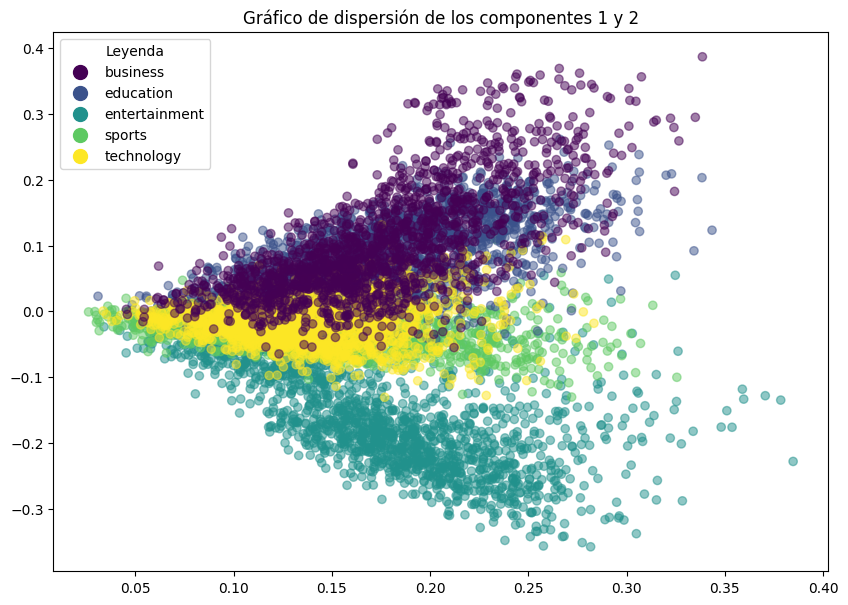

In [43]:
draw_components(unique_labels, tfidf_df, Y_train, 2)

#### Punto 2: Identificar el número de componentes principales apropiado el procesamiento. Genera una tabla comparativa y los gráficos que apoyen este proceso. Recuerda que no deben truncarse los textos. Por último, la elección del número de componentes debe estar debidamente justificada.

100%|██████████| 10/10 [1:21:18<00:00, 487.85s/it]


   Explained Variance  Number of Components
0                0.80                  2032
1                0.82                  2199
2                0.84                  2386
3                0.86                  2596
4                0.88                  2836
5                0.90                  3113
6                0.92                  3442
7                0.94                  3848
8                0.96                  4381
9                0.98                  5179


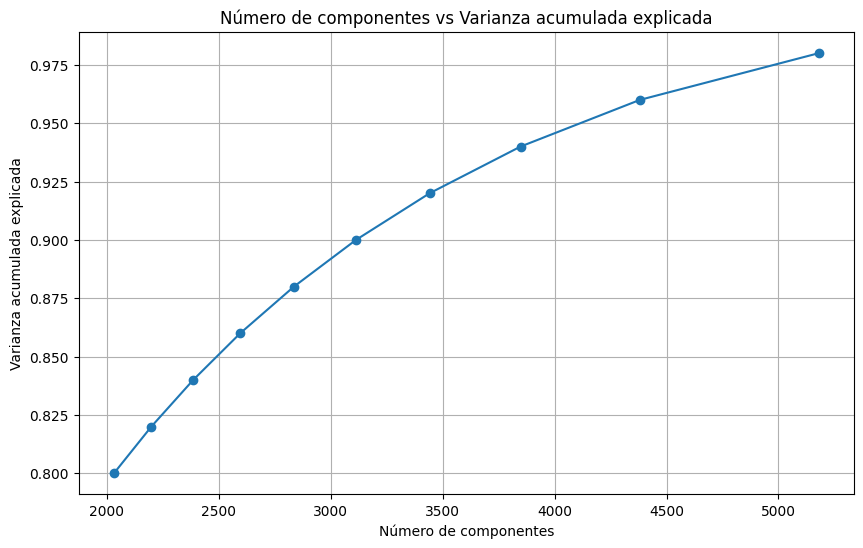

''

In [44]:
""""""
results = []
from tqdm import tqdm
import pickle
# Loop over the range of values
for i in tqdm(range(80, 100,2)):
    ratio = i / 100.0
    pca = PCA(ratio, whiten=True)
    pca.fit(X_train_TFID.toarray())
    exp_var_ratio = round(sum(pca.explained_variance_ratio_), 3)
    n_components = pca.n_components_
    results.append([exp_var_ratio, n_components])

    with open(f'pca/pca_{ratio}.pkl', 'wb') as f:
        pickle.dump(pca, f)

# Convert the results into a DataFrame
df = pd.DataFrame(results, columns=['Explained Variance', 'Number of Components'])

# Print the DataFrame
print(df)
plt.figure(figsize=(10,6))
plt.plot(df['Number of Components'], df['Explained Variance'], marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada explicada')
plt.title('Número de componentes vs Varianza acumulada explicada')
plt.grid(True)
plt.show()
""""""

Se observa que con un mayor número de componentes hay una mayor varianza explicada. En este caso una varianza del 0.90 es suficiente para eplicar la mayoría de la información. Por lo que se elige tener una varinza del 0.9 con un número de componentes de 3113.

#### Punto 3: Construir la red neuronal tomando los PCA del punto anterior